In [1]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import Draw

from rgroup import rep2D, draw3D, draw3Dcons, merge_R_group, tox_props, Mol, generate_conformers

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
# load the complex with the ligand
sys = prody.parsePDB('5NEV.pdb1')
rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname 72L')

prody.writePDB('rec.pdb', rec)
prody.writePDB('lig.pdb', mol)

@> 4485 atoms and 1 coordinate set(s) were parsed in 0.04s.


'lig.pdb'

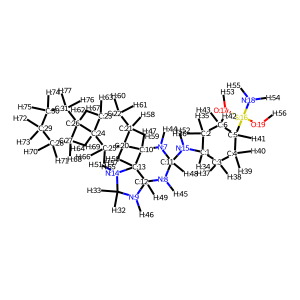

In [3]:
# load the ligand
init_mol = Chem.MolFromPDBFile('lig.pdb')
init_mol = Chem.AddHs(init_mol, addCoords=True)

# select the atom to be replaced with the R group
Draw.MolToImage(rep2D(init_mol))

In [4]:
# load the R group
R_group = Chem.MolFromMolFile('data/rgroups/molecules/alcohols/methanol-r.mol', removeHs=False)
draw3D(init_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
mol = merge_R_group(init_mol, R_group, 72)
draw3D(mol)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fb166d76f80> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fb166d76e90>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

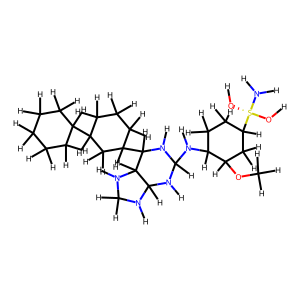

In [6]:
Draw.MolToImage(rep2D(mol, idx=False))

In [7]:
toxicity = tox_props(mol)
toxicity

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs
0,500.35086,9,8,2.2131,False,False,False


In [8]:
# visualise the template
draw3D(mol.template)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
draw3D(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
cons = generate_conformers(mol, mol.template, num_conf=20, minimum_conf_rms=0.5)

[17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:08] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)


[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:09] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:10] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:11] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)


[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:12] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)


RDKit ERROR: [17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:13] UFFTYPER: Unrecognized atom type: S_5+4 (16)
RDKit ERROR: [17:44:14] UFFTYPER: Unrecognized atom type: S_5+4 (16)
[17:44:14] UFFTYPER: Unrecognized atom type: S_5+4 (16)


In [11]:
draw3Dcons(cons)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
cons.GetNumConformers()

2